In [51]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

In [52]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [53]:
def GaussianFilter(df, window_length):
    df1 = df
    
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    df1['AX1'] = gaussian_filter(df['AX1'], window_length)
    df1['AY1'] = gaussian_filter(df['AY1'], window_length)
    df1['AZ1'] = gaussian_filter(df['AZ1'], window_length)

    df1['GX1'] = gaussian_filter(df['GX1'], window_length)
    df1['GY1'] = gaussian_filter(df['GY1'], window_length)
    df1['GZ1'] = gaussian_filter(df['GZ1'], window_length)
    return df1

In [54]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [55]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        roll1 = atan(y/z)*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((z/((x*x + z*z)**(1/2))))*57.3
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
    
    df['orientX'] = pitch
    df['orientY'] = roll
    df['orientZ'] = yaw
    
    return df

In [56]:
def getQuat(df):

        """ Given 3 orientation angles, compute the quaternion. """

        yaw   = df['orientZ'] / 2. * np.pi / 180
        roll  = df['orientX'] / 2. * np.pi / 180
        pitch = df['orientY'] / 2. * np.pi / 180

        w =  np.cos(roll) * np.cos(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.sin(pitch) * np.sin(yaw)

        x =  np.sin(roll) * np.cos(pitch) * np.cos(yaw) - \
                np.cos(roll) * np.sin(pitch) * np.sin(yaw)

        y =  np.cos(roll) * np.sin(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.cos(pitch) * np.sin(yaw)

        z =  np.cos(roll) * np.cos(pitch) * np.sin(yaw) - \
                np.sin(roll) * np.sin(pitch) * np.cos(yaw)

        return w, x, y, z

In [60]:
"""
Rotate a 3D vector using the axis-angle method (quaternions).
"""

import numpy as np


def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return v

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    return w, x, y, z

def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w) * 2.0
    return normalize(v), theta

In [61]:
def get_rotation(quatern, vector):
    rotaedvector = []
    for i in range(vector.shape[0]):
        rotaedvector.append(qv_mult(tuple(quatern[i,:]), tuple(vector[i,:])))
    return np.array(rotaedvector)

In [62]:
def rotate(df):
    features = ['A', 'G']
    quaternion = df[['quaternionW', 'quaternionX',
                     'quaternionY','quaternionZ']].values
    
    for f in features:
        xyzlist = [f + 'X', f + 'Y', f + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = get_rotation(quaternion, xyz)
        df[f + 'X1'] = xyz_rotated[:,0]
        df[f + 'Y1'] = xyz_rotated[:,1]
        df[f + 'Z1'] = xyz_rotated[:,2]
        
    return df
        

In [63]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [64]:
def data_preprocessing(df):
#     df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 10
    df = Yaw_Roll_Pitch(df)
    qw, qx, qy, qz = getQuat(df)
    df['quaternionW'] = qw
    df['quaternionX'] = qx
    df['quaternionY'] = qy
    df['quaternionZ'] = qz
    df = rotate(df)
    df = GaussianFilter(df, 10)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df
    
    
    
    
    

In [65]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
#         gx = df['GX'].values[i: i + N_TIME_STEPS]
#         gy = df['GY'].values[i: i + N_TIME_STEPS]
#         gz = df['GZ'].values[i: i + N_TIME_STEPS]
#         ax = df['AX'].values[i: i + N_TIME_STEPS]
#         ay = df['AY'].values[i: i + N_TIME_STEPS]
#         az = df['AZ'].values[i: i + N_TIME_STEPS]
        
        gx1 = df['GX1'].values[i: i + N_TIME_STEPS]
        gy1 = df['GY1'].values[i: i + N_TIME_STEPS]
        gz1 = df['GZ1'].values[i: i + N_TIME_STEPS]
        ax1 = df['AX1'].values[i: i + N_TIME_STEPS]
        ay1 = df['AY1'].values[i: i + N_TIME_STEPS]
        az1 = df['AZ1'].values[i: i + N_TIME_STEPS]
        label = "ST"
        segments.append([ax1, ay1, az1, gx1, gy1, gz1])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [66]:
# def segmentation(df, N_TIME_STEPS):
    
#     N_FEATURES = 1
#     step = 50
#     segments = []
#     features = ['AX','AY','AZ','GX','GY','GZ']
#     labels = []
#     for i in range(0, len(df) - N_TIME_STEPS, step):
#         for j in features:
#             s = df[j].values[i: i + N_TIME_STEPS]
#             segments.append(s)
        
# #         gy = df['GY'].values[i: i + N_TIME_STEPS]
# #         gz = df['GZ'].values[i: i + N_TIME_STEPS]
# #         ax = df['AX'].values[i: i + N_TIME_STEPS]
# #         ay = df['AY'].values[i: i + N_TIME_STEPS]
# #         az = df['AZ'].values[i: i + N_TIME_STEPS]
#         label = "ST"
# #         segments.append([gx, gy, gz, ax, ay, az])
# #         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
#         labels.append(label)
#     return segments, labels

In [67]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [68]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if(ind-r>=0) else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if(ind-r>=0) else 0):(ind+r)])

        if(i>upper_bound):
            LB_sum=LB_sum+(i-upper_bound)**2
        elif(i<lower_bound):
            LB_sum=LB_sum+(i-lower_bound)**2

    return (LB_sum)**(1/2)

In [69]:
def loss_for_segments(segments, comp, feature):
    loss =[]
    labels=[]
    length = len(segments)
    for i in range(length):
        x = segments[i][feature]        
        dist = DTWDistance(x, comp, 50)
        print(i , '=>', dist)
#         if(dist<2):
#             this_label ='LT'
#         elif(dist>4):
#             this_label ='RT'
#         else:
#             this_label ='ST'
#         labels.append(this_label)
        loss.append(dist)
    
    return loss

In [70]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [71]:
# Function to map the colors as a list from the input list of x variables
def color_mapping(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [72]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)

    df = data_preprocessing(df)
    
    return df
    

In [92]:
  
path_acc = os.getcwd() + '/data/Car1109out/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car1109out/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df= read_files(acc_files[0], gyro_files[0], 'bike')
n = len(df)
df = df[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df = pd.concat([df, df_this])
    print(df.shape)
df.reset_index(drop = True, inplace = True)
df.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/Gyroscope.csv
len of this file  (3622, 28)
len of this file  (2772, 28)
(5544, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/Gyroscope.csv
len of this file  (6310, 28)
len of this file  (5460, 28)
(11004, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/Gyroscope.csv
len of this file  (2872, 28)
len of this file  (2022, 28)
(13026, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/Gyros

,AX,AY,AZ,GX,GY,GZ,activity,orientX,orientY,orientZ,...,GY1,GZ1,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,0.151147,-0.548212,0.384174,0.014104,0.032599,0.212953,bike,-2.105947,-22.135528,44.980761,...,-0.065251,0.194360,-0.004297,0.086552,-0.469010,0.643091,1.045992,-0.469010,0.643091,1.045992
1,0.145558,-0.549001,0.315767,0.022043,0.024087,0.209872,bike,-10.407979,-21.358636,44.456801,...,-0.070148,0.191415,-0.029225,0.085334,1.508135,0.300526,3.560223,1.508135,0.300526,3.560223
2,0.131640,-0.550599,0.237944,0.029397,0.016481,0.205640,bike,-33.960476,-40.116953,36.890751,...,-0.073003,0.186786,-0.060338,0.083839,-0.479914,-0.919118,-0.239622,-0.479914,-0.919118,-0.239622
3,0.109519,-0.552682,0.153242,0.035762,0.010158,0.200435,bike,-59.080153,73.602775,-9.470264,...,-0.073536,0.180548,-0.096640,0.082119,1.438879,0.072317,3.113115,1.438879,0.072317,3.113115
4,0.079650,-0.554942,0.064491,0.040765,0.005447,0.194477,bike,-33.272546,4.498588,-39.875493,...,-0.071550,0.172831,-0.136934,0.080230,0.231024,-0.323009,0.435065,0.231024,-0.323009,0.435065


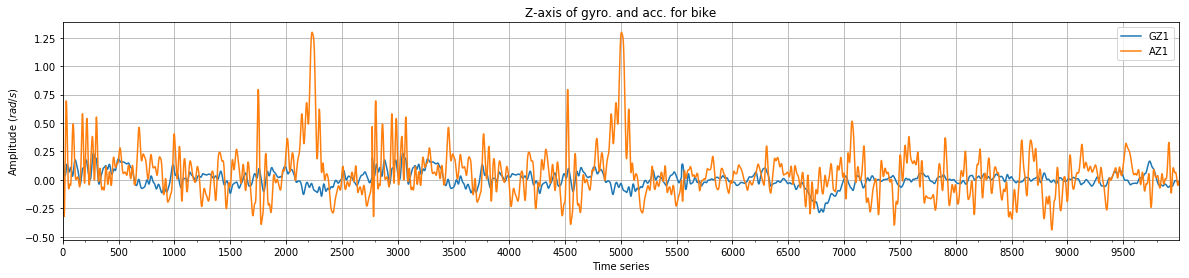

In [96]:

s = 0
m = s + 10000
fig, ax = plt.subplots()
df[['GZ1','AZ1']][s:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. and acc. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
# n = len(df[s:m])
major_ticks = np.arange(s, m, 500)
minor_ticks = np.arange(s, m, 200)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)


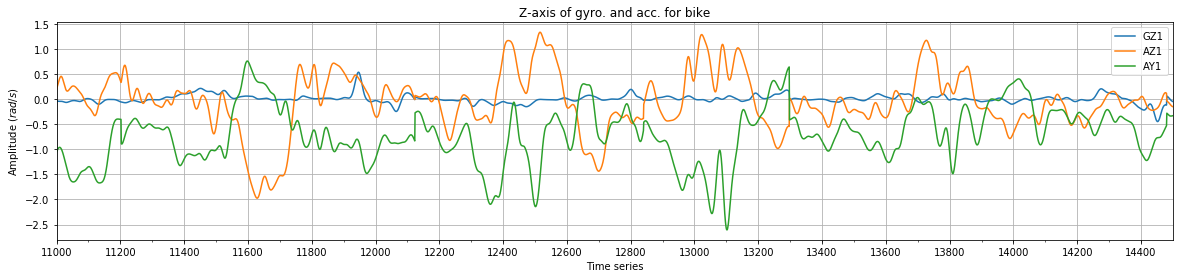

In [314]:

s = 11000
m = s + 3500
fig, ax = plt.subplots()
df[['GZ1','AZ1','AY1']][s:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. and acc. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
# n = len(df[s:m])
major_ticks = np.arange(s, m, 200)
minor_ticks = np.arange(s, m, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)


In [50]:
x = car_segments[272][2]
xx = pd.Series(x)
xx.plot(figsize = (7,3))
# x = car_segments[125][1]
# xx = pd.Series(x)
# xx.plot(figsize = (7,3))
plt.grid(True)



NameError: name 'car_segments' is not defined

In [184]:
car_segments, car_labels = segmentation(df, 400)
np.array(car_segments).shape


(683, 6, 400)

In [104]:
def DTWdistance(segments, ref_seg_no):
    y = segments
    DTW_list = []
    for i in range(len(segments[1])):
        x = segments[ref_seg_no][i]
        diff = loss_for_segments(y, x, i)
        DTW_list.append(diff)
    
    return DTW_list
        

In [105]:
ref_seq_no = 17
dtw_data = DTWdistance(car_segments, ref_seq_no)

0 => 7.82545939635
1 => 2.61924970641
2 => 0.0268792372756
3 => 1.22229007033
4 => 8.71562177376
5 => 8.27909556503
6 => 5.71446294013
7 => 4.59853463503
8 => 5.52387033804
9 => 8.58162179209
10 => 9.16517893123
11 => 8.30324087892
12 => 6.47008161683
13 => 4.60558536781
14 => 7.53557298497
15 => 8.04125897578
16 => 2.54069283757
17 => 0.0
18 => 0.701099106758
19 => 8.59366158002
20 => 8.32682563208
21 => 5.4955397782
22 => 4.12858848397
23 => 6.91106135375
24 => 11.0623315822
25 => 11.9389247473
26 => 9.54092888391
27 => 8.15568477978
28 => 11.4071471176
29 => 14.5258562775
30 => 16.5446614055
31 => 15.1399299692
32 => 14.7448348587
33 => 15.29833028
34 => 15.4227407096
35 => 15.1137134668
36 => 14.1248709562
37 => 13.1642872989
38 => 12.7411527407
39 => 9.14268113865
40 => 9.44944884533
41 => 9.94871895033
42 => 12.0503137941
43 => 11.5228814914
44 => 13.7452812164
45 => 14.2655873677
46 => 12.8797520955
47 => 9.98135392949
48 => 6.98867838904
49 => 5.70168885743
50 => 7.00056416651


398 => 14.1833299499
399 => 15.1052795714
400 => 16.4770880368
401 => 16.5615859112
402 => 17.1810884827
403 => 14.5790759961
404 => 12.4421066007
405 => 13.2759730983
406 => 15.1675346367
407 => 17.3978589616
408 => 16.3116911204
409 => 13.3655329218
410 => 10.3018136443
411 => 9.46138198897
412 => 9.12109940374
413 => 8.56729669453
414 => 10.0380599289
415 => 11.0312975809
416 => 10.7527301347
417 => 11.3330761606
418 => 13.2943711456
419 => 16.5286111987
420 => 15.2376327084
421 => 13.0706017421
422 => 12.4151441132
423 => 9.46853184587
424 => 6.98437136355
425 => 4.13058626685
426 => 5.12948632321
427 => 7.93193160913
428 => 11.2658380583
429 => 10.1869166122
430 => 8.74116759897
431 => 7.32723200912
432 => 9.03706940405
433 => 11.2343574274
434 => 12.9428012692
435 => 10.7965035989
436 => 11.6721751366
437 => 13.9033121919
438 => 12.9465733936
439 => 9.64265665775
440 => 6.87528367527
441 => 6.14976961364
442 => 7.05579378872
443 => 7.80387434243
444 => 7.3110366674
445 => 7.52910

507 => 15.401652122
508 => 16.47513465
509 => 18.2626007774
510 => 21.1366437224
511 => 22.1445958861
512 => 20.5375416667
513 => 16.2787376135
514 => 14.5154053346
515 => 12.2462188023
516 => 12.7666313424
517 => 10.4667381939
518 => 7.89419598477
519 => 8.92785655462
520 => 11.3970499403
521 => 13.6450848289
522 => 13.8770418261
523 => 13.5057768866
524 => 13.6370467047
525 => 12.4164776313
526 => 8.43321815677
527 => 3.40616853489
528 => 4.89478333006
529 => 9.4802888489
530 => 12.9803843476
531 => 11.8502108666
532 => 13.2358468658
533 => 13.7621765465
534 => 14.3588799673
535 => 12.8305374743
536 => 13.755779632
537 => 16.8966711397
538 => 16.4636783613
539 => 14.513130789
540 => 14.1492354248
541 => 9.12751229357
542 => 5.14665138993
543 => 7.16975096457
544 => 9.30552007891
545 => 13.7548898996
546 => 16.5262564166
547 => 16.7080410726
548 => 15.6393283832
549 => 15.5983439053
550 => 14.8224650372
551 => 12.6437126952
552 => 11.6191331667
553 => 11.8501785438
554 => 13.358703103

225 => 20.0264499656
226 => 10.8010352319
227 => 4.22622856483
228 => 3.23607551656
229 => 8.52258830236
230 => 17.8307321055
231 => 23.0856773084
232 => 28.0782005866
233 => 26.5628717211
234 => 19.640859468
235 => 17.8675826527
236 => 18.1678283095
237 => 18.2611540682
238 => 14.1764164213
239 => 10.4281114563
240 => 11.6502724356
241 => 13.6669067503
242 => 16.6505160162
243 => 22.079660467
244 => 27.3621277358
245 => 28.9702711459
246 => 24.2949709377
247 => 16.7670838858
248 => 13.5066745781
249 => 10.6070191094
250 => 10.6177720944
251 => 12.863568462
252 => 16.0335202958
253 => 18.812907301
254 => 19.9468876951
255 => 24.0648695948
256 => 25.6592373035
257 => 24.5785353379
258 => 21.2634274639
259 => 15.3365724131
260 => 12.9402235027
261 => 13.1653485985
262 => 14.1888461747
263 => 11.997886565
264 => 14.6856776938
265 => 15.0827243677
266 => 13.5317764341
267 => 14.3710184961
268 => 18.6027965249
269 => 21.7162596878
270 => 23.8910689017
271 => 23.1983417294
272 => 20.42826897

619 => 10.4464390232
620 => 10.3991777052
621 => 11.1079191124
622 => 15.1255919293
623 => 15.1012390846
624 => 16.2427492502
625 => 15.4072289144
626 => 14.0903476086
627 => 16.1040329613
628 => 18.0581095513
629 => 18.7967653607
630 => 25.5297157426
631 => 32.7549615549
632 => 31.3915592482
633 => 25.946198647
634 => 23.2300946345
635 => 17.4896535333
636 => 14.1103423212
637 => 9.05976085674
638 => 10.7041370947
639 => 16.4769602114
640 => 16.4678709743
641 => 18.2185099329
642 => 21.6967192965
643 => 22.6229142697
644 => 20.7491403331
645 => 21.1299561241
646 => 17.1406326587
647 => 14.4844864536
648 => 15.8631165133
649 => 14.9243088571
650 => 16.0884687834
651 => 15.8357226321
652 => 18.2805243585
653 => 22.9000312286
654 => 26.7925023249
655 => 23.2619027817
656 => 19.880708881
657 => 14.4575691178
658 => 9.5824974815
659 => 7.31312668491
660 => 10.7652708407
661 => 13.2945405931
662 => 17.8782683129
663 => 21.1764105951
664 => 17.5881859732
665 => 20.3084025446
666 => 25.746193

49 => 3.59666923423
50 => 3.36528770186
51 => 3.31805522639
52 => 3.71255985247
53 => 4.19003963803
54 => 4.61391292415
55 => 5.22230744616
56 => 5.23314399692
57 => 4.59990491032
58 => 3.98078664675
59 => 3.83191824912
60 => 3.54383761663
61 => 3.43013519331
62 => 3.55771214544
63 => 3.81775037877
64 => 4.37495612253
65 => 4.13663222039
66 => 3.35762745295
67 => 1.61134876089
68 => 0.504822529996
69 => 0.927712605567
70 => 2.28762340562
71 => 3.9735155125
72 => 4.7776211477
73 => 4.86219848211
74 => 4.07226012265
75 => 3.61786251361
76 => 3.75879873225
77 => 4.3706840107
78 => 3.94537068415
79 => 2.94479464362
80 => 1.42204940344
81 => 1.2743965996
82 => 1.37808169594
83 => 2.6255900083
84 => 3.94996978512
85 => 3.96251228197
86 => 4.2715821856
87 => 3.87838650839
88 => 3.56630161502
89 => 3.41616654445
90 => 3.82785703089
91 => 3.84279149768
92 => 3.89932744145
93 => 2.94367686715
94 => 1.60940470825
95 => 1.12055143509
96 => 0.912213163545
97 => 1.74403757979
98 => 3.02910698647
99 

445 => 3.42463472269
446 => 3.24973785098
447 => 3.96237565367
448 => 4.72586741238
449 => 5.26217038428
450 => 5.1236651749
451 => 4.38669306133
452 => 4.04806055821
453 => 3.71552447522
454 => 3.49985880226
455 => 3.70604519643
456 => 3.62259263654
457 => 3.69710328798
458 => 3.66732579526
459 => 3.47043311628
460 => 3.44432582801
461 => 3.29542108995
462 => 3.75022308633
463 => 4.58537605959
464 => 4.88069462134
465 => 5.26427870274
466 => 4.39903963722
467 => 3.95180081742
468 => 3.93181903947
469 => 3.6850683015
470 => 3.55987191699
471 => 3.35071789628
472 => 3.523857787
473 => 4.11561218206
474 => 3.99867721257
475 => 3.31630029336
476 => 1.79358908542
477 => 1.00580738714
478 => 1.10375211194
479 => 1.73394761138
480 => 3.18702155529
481 => 3.59849186137
482 => 3.61607626381
483 => 3.76627397523
484 => 3.51701346206
485 => 3.5451571626
486 => 3.76582247585
487 => 3.61550679618
488 => 3.64492576189
489 => 3.46787860533
490 => 2.7173759845
491 => 2.19260805246
492 => 2.6373584795

552 => 1.6296939674
553 => 2.12922030525
554 => 2.27826764701
555 => 2.75065112406
556 => 2.81948691062
557 => 3.03983146003
558 => 2.97243030307
559 => 2.78916546678
560 => 2.84906189652
561 => 2.60060674393
562 => 2.42278949603
563 => 1.62078914583
564 => 1.44768488353
565 => 1.66951716433
566 => 0.924075331067
567 => 1.09323886832
568 => 1.56699007307
569 => 0.981669829218
570 => 1.26600628363
571 => 1.55273791102
572 => 1.50072258122
573 => 1.62587841964
574 => 1.44591635372
575 => 1.42815962495
576 => 1.34403519989
577 => 1.27240656844
578 => 1.2834955807
579 => 1.5982658565
580 => 1.32708757154
581 => 1.24163569518
582 => 1.37331067001
583 => 0.753106329012
584 => 0.665285761894
585 => 0.700016735445
586 => 1.07855761954
587 => 1.20078384927
588 => 1.05850911143
589 => 1.3295633446
590 => 1.42078248285
591 => 1.2341655168
592 => 1.34951632908
593 => 1.33563729524
594 => 1.21150263233
595 => 1.12658648983
596 => 1.22446864549
597 => 1.41523643716
598 => 1.54561297845
599 => 1.2996

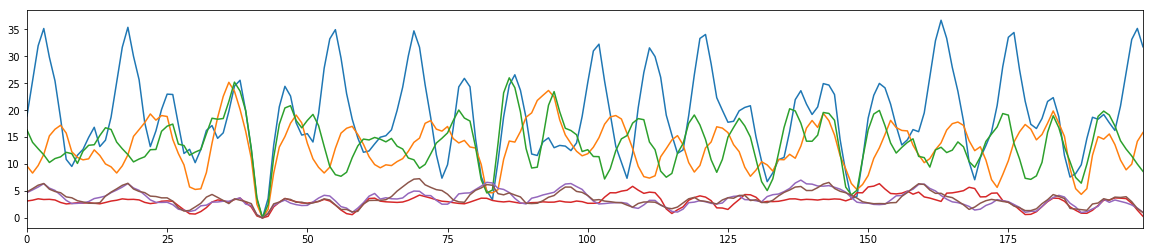

In [58]:
loss_series_st = pd.Series(dtw_data[5])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[4])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[3])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[2])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[1])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[0])
loss_series_st[0:200].plot(figsize = (20,4))

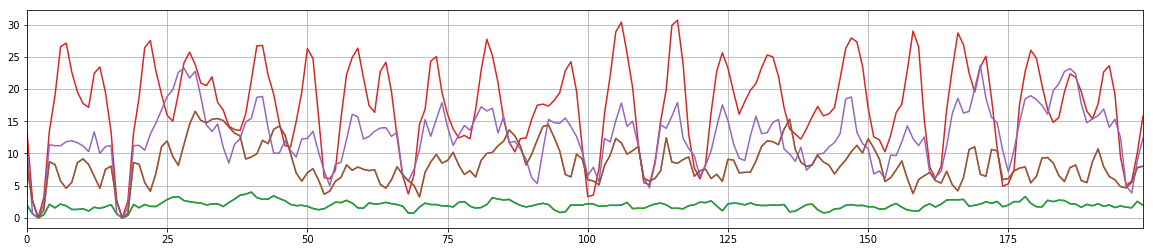

In [133]:
temp = dtw_data[0] + dtw_data[1] + dtw_data[2] + dtw_data[3] + dtw_data[4] + dtw_data[5] 
loss_series_st = pd.Series(dtw_data[3])
loss_series_st[0:200].plot(figsize = (20,4))

loss_series_st = pd.Series(temp)
loss_series_st[0:200].plot(figsize = (20,4))

loss_series_st = pd.Series(dtw_data[3])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[2])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[1])
loss_series_st[0:200].plot(figsize = (20,4))
loss_series_st = pd.Series(dtw_data[0])
loss_series_st[0:200].plot(figsize = (20,4))
plt.grid(True)

In [61]:
path_acc = os.getcwd() + '/data/Car1109out/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car1109out/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df1= read_files(acc_files[0], gyro_files[0], 'car')
n = len(df1)
df1 = df1[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df1 = pd.concat([df1, df_this])
    print(df1.shape)
df1.reset_index(drop = True, inplace = True)
df1.head()

/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/Gyroscope.csv
len of this file  (3622, 15)
len of this file  (2772, 15)
(5544, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/Gyroscope.csv
len of this file  (6310, 15)
len of this file  (5460, 15)
(11004, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/Gyroscope.csv
len of this file  (2872, 15)
len of this file  (2022, 15)
(13026, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/Gyros

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,0.151147,-0.548212,0.384174,0.014104,0.032599,0.212953,car,-0.004297,0.086552,-0.469010,0.643091,1.045992,-0.469010,0.643091,1.045992
1,0.145558,-0.549001,0.315767,0.022043,0.024087,0.209872,car,-0.029225,0.085334,1.508135,0.300526,3.560223,1.508135,0.300526,3.560223
2,0.131640,-0.550599,0.237944,0.029397,0.016481,0.205640,car,-0.060338,0.083839,-0.479914,-0.919118,-0.239622,-0.479914,-0.919118,-0.239622
3,0.109519,-0.552682,0.153242,0.035762,0.010158,0.200435,car,-0.096640,0.082119,1.438879,0.072317,3.113115,1.438879,0.072317,3.113115
4,0.079650,-0.554942,0.064491,0.040765,0.005447,0.194477,car,-0.136934,0.080230,0.231024,-0.323009,0.435065,0.231024,-0.323009,0.435065


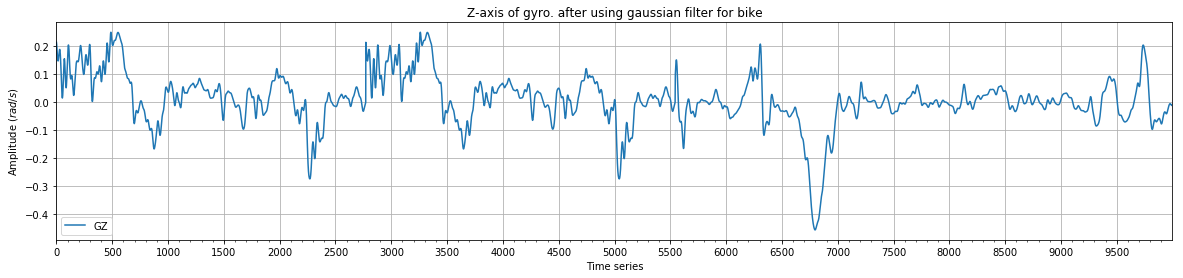

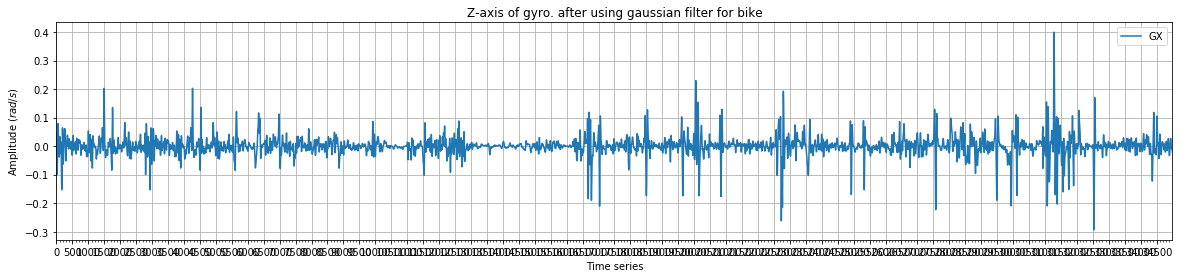

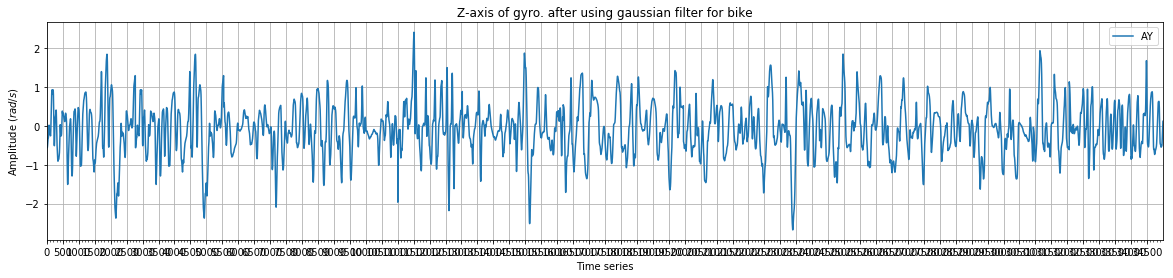

In [69]:
fig, ax = plt.subplots()
m=35000
df1[['GZ']][0:10000].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:10000])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

fig, ax = plt.subplots()
df1[['GX']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)
fig, ax = plt.subplots()
df1[['AY']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [65]:
car_segments1, car_labels1 = segmentation(df1, 500)
np.array(car_segments1).shape
len(car_segments1)

1397

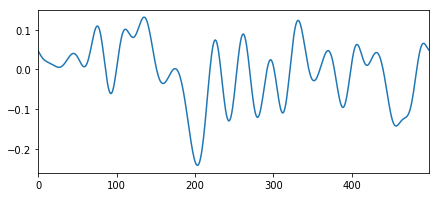

In [84]:
x = car_segments1[129][5]
xx = pd.Series(x)
xx.plot(figsize = (7,3))
# x = car_segments1[130][4]
# xx = pd.Series(x)
# xx.plot(figsize = (7,3))
# x = car_segments1[130][3]
# xx = pd.Series(x)
# xx.plot(figsize = (7,3))

In [85]:
ref_seq_no = 129
dtw_data_for_car = DTWdistance(car_segments1, ref_seq_no)

0 => 0.734393474917
1 => 0.611256369504
2 => 0.600041324907
3 => 0.626267442322
4 => 0.356104785288
5 => 0.411970903969
6 => 0.202618612806
7 => 0.227466343764
8 => 0.267724617565
9 => 0.354766748802
10 => 0.296397706359
11 => 0.346020325637
12 => 0.259194369018
13 => 0.391436272507
14 => 0.389351980737
15 => 0.419092557816
16 => 0.43065993035
17 => 0.395153188918
18 => 0.448733931516
19 => 0.377567028559
20 => 0.689635520979
21 => 0.751246461653
22 => 0.759535122141
23 => 0.680022560506
24 => 0.771263141176
25 => 0.782635895666
26 => 0.844955488333
27 => 0.833941598086
28 => 0.80447497824
29 => 0.861646669849
30 => 0.715952157575
31 => 0.496381669995
32 => 0.411328823767
33 => 0.490005069743
34 => 0.566835926519
35 => 0.542190583987
36 => 0.371006230223
37 => 0.492359868387
38 => 0.380995831952
39 => 0.416706924278
40 => 0.314110358283
41 => 0.370128551123
42 => 0.322281102102
43 => 0.313725464884
44 => 0.28264170692
45 => 0.316406049285
46 => 0.487998572103
47 => 0.457359995051
48 =>

380 => 0.290697248218
381 => 0.236677331553
382 => 0.264124474219
383 => 0.825612005209
384 => 0.832363325098
385 => 0.857454869792
386 => 0.809562233196
387 => 0.745240310134
388 => 0.745469533389
389 => 0.725157546679
390 => 0.749366215073
391 => 0.885661763504
392 => 1.18896175333
393 => 1.07421233836
394 => 1.17739314718
395 => 1.23520585021
396 => 1.23430177762
397 => 1.18872448429
398 => 1.13181698236
399 => 1.18349683125
400 => 1.17448782997
401 => 1.14704471036
402 => 0.904506953172
403 => 0.719724052575
404 => 0.384275704063
405 => 0.351719675765
406 => 0.280918907845
407 => 0.858755142499
408 => 0.872474657112
409 => 0.870953173331
410 => 0.81943115133
411 => 0.763362065672
412 => 0.819246147051
413 => 0.782442555634
414 => 0.750336854226
415 => 0.751043739979
416 => 0.955532644486
417 => 0.527494054763
418 => 0.243081539065
419 => 0.247779737959
420 => 0.285360053431
421 => 0.292051302488
422 => 0.293633026323
423 => 0.324150349917
424 => 0.279108191471
425 => 0.323242620418

1127 => 0.395656382505
1128 => 0.428565029747
1129 => 0.416502476554
1130 => 0.338356877386
1131 => 0.315751543895
1132 => 0.370104901655
1133 => 0.348927051828
1134 => 0.269597133519
1135 => 0.290891062877
1136 => 0.395911399453
1137 => 0.364125174217
1138 => 0.256307933374
1139 => 0.250223273003
1140 => 0.279855722172
1141 => 0.32062057985
1142 => 0.246212133313
1143 => 0.356926897146
1144 => 0.215595320503
1145 => 0.254779791181
1146 => 0.323238448318
1147 => 0.189168573345
1148 => 0.272275831013
1149 => 0.842570361166
1150 => 0.917551403416
1151 => 0.918816979772
1152 => 0.943141724461
1153 => 0.841746154864
1154 => 0.835268812373
1155 => 0.856187468254
1156 => 0.842964213525
1157 => 0.857541513903
1158 => 0.926732005183
1159 => 0.52256553833
1160 => 0.528348759941
1161 => 0.555313839038
1162 => 0.277358989886
1163 => 0.211101378128
1164 => 0.457875804002
1165 => 0.451081330356
1166 => 0.422605309922
1167 => 0.448664044606
1168 => 0.441103333541
1169 => 0.408638601317
1170 => 0.438

98 => 0.917865529012
99 => 0.870924626451
100 => 1.00048368705
101 => 0.891155279085
102 => 0.847923056176
103 => 0.984170933912
104 => 1.12969664177
105 => 1.13361183454
106 => 1.07654027251
107 => 0.985495950961
108 => 0.952884075938
109 => 0.922223734674
110 => 0.881410664124
111 => 0.86406813858
112 => 0.974082907967
113 => 0.976701580649
114 => 1.05162421422
115 => 0.869450634835
116 => 0.737209370759
117 => 0.995723606083
118 => 1.0429958257
119 => 1.15962979756
120 => 1.02679780865
121 => 1.05212561083
122 => 1.07136730868
123 => 1.18781099921
124 => 0.884603044774
125 => 0.660552281849
126 => 0.669299023887
127 => 0.509340244326
128 => 0.183773835114
129 => 0.0
130 => 0.303680944547
131 => 0.6335215707
132 => 0.641901346586
133 => 0.786131640086
134 => 0.968184814084
135 => 1.04909465317
136 => 1.10038445102
137 => 1.01196659771
138 => 1.04770245806
139 => 0.861044925279
140 => 0.823578785108
141 => 0.797929599783
142 => 0.762420763593
143 => 0.782013718552
144 => 0.91314788755

477 => 0.848735582275
478 => 0.783844029163
479 => 0.801817513339
480 => 0.867490080635
481 => 0.789397068385
482 => 0.853000478752
483 => 0.853898266044
484 => 0.920398587046
485 => 0.926746596178
486 => 0.867031082389
487 => 0.875084964752
488 => 0.930558056805
489 => 0.866721715547
490 => 0.871046701512
491 => 0.90430004938
492 => 0.92097721239
493 => 0.91952817477
494 => 0.890632669235
495 => 0.906739466311
496 => 0.857301572017
497 => 0.886789404411
498 => 0.863127640495
499 => 0.843873380551
500 => 0.871250076307
501 => 0.93459063263
502 => 0.884885710091
503 => 0.758593318575
504 => 0.702246341045
505 => 0.792346313545
506 => 0.854788295258
507 => 0.817759827191
508 => 0.728852617142
509 => 0.797260606637
510 => 0.823883825925
511 => 0.924070964215
512 => 0.844332255333
513 => 0.869447306145
514 => 0.729972940585
515 => 0.75929101514
516 => 0.799657802247
517 => 0.839686876894
518 => 0.854806947229
519 => 0.914379433934
520 => 1.15566423381
521 => 1.30665517444
522 => 1.28133241

857 => 0.74420153081
858 => 0.648785573473
859 => 0.728044470495
860 => 0.787957431425
861 => 0.777399599011
862 => 0.869519938155
863 => 0.941183982392
864 => 0.971333743043
865 => 1.0717013669
866 => 1.23076190883
867 => 1.22562607198
868 => 1.30326432501
869 => 1.38053587206
870 => 1.25696926736
871 => 1.02176485294
872 => 0.932537848435
873 => 0.701985037763
874 => 0.870855064116
875 => 0.985134532973
876 => 0.866765017077
877 => 0.888792353421
878 => 0.949480019913
879 => 0.836818452808
880 => 0.893129211953
881 => 0.819145721374
882 => 0.784783143765
883 => 0.734937177582
884 => 0.793335294653
885 => 0.631511761041
886 => 0.563516301546
887 => 0.344124914945
888 => 0.377973926124
889 => 0.44743027143
890 => 0.606037659486
891 => 0.470600570899
892 => 0.757181229347
893 => 0.930610260708
894 => 1.08116728809
895 => 1.18507358088
896 => 1.26913127866
897 => 1.26314888988
898 => 1.2929475996
899 => 1.02269409574
900 => 0.878065743194
901 => 0.789745024785
902 => 0.818714894619
903 =

1226 => 1.01530398349
1227 => 1.03143153874
1228 => 1.02616548065
1229 => 1.08686679794
1230 => 1.1241253572
1231 => 1.05841236166
1232 => 1.13906910303
1233 => 1.2686038187
1234 => 1.16574845165
1235 => 1.11670842142
1236 => 1.0110881723
1237 => 0.979880852088
1238 => 0.868062220002
1239 => 0.880246035287
1240 => 0.83670823536
1241 => 0.858440160825
1242 => 0.695723153119
1243 => 0.720434493402
1244 => 0.855620669983
1245 => 0.764647982933
1246 => 0.756784633238
1247 => 0.805522185069
1248 => 0.835036098075
1249 => 0.871735493257
1250 => 0.808110907424
1251 => 0.745262624992
1252 => 0.731616825779
1253 => 0.664925987704
1254 => 0.671130374276
1255 => 0.731586462194
1256 => 0.709259795735
1257 => 0.749795022543
1258 => 0.815600964958
1259 => 0.864212227517
1260 => 0.800349474408
1261 => 0.665390065546
1262 => 0.592415731815
1263 => 0.658488657449
1264 => 0.71154332089
1265 => 0.761541427328
1266 => 0.790910940712
1267 => 0.802981139906
1268 => 0.868788315368
1269 => 0.982393375253
1270

213 => 6.76108064731
214 => 6.48778844025
215 => 5.9936163034
216 => 5.62801320045
217 => 5.34651767146
218 => 5.18541003968
219 => 5.07593434118
220 => 4.52219722312
221 => 4.38354684164
222 => 4.36192222505
223 => 4.48183336743
224 => 4.2402995663
225 => 4.57432566448
226 => 4.88899303426
227 => 4.9865619493
228 => 4.86801446332
229 => 4.90378014615
230 => 4.97999388248
231 => 4.8793164782
232 => 4.8787310462
233 => 4.94746116262
234 => 4.9852539616
235 => 4.88028322583
236 => 4.72179336174
237 => 4.53111849822
238 => 4.05503148372
239 => 4.09275807381
240 => 4.2731365371
241 => 4.5685754885
242 => 4.77834176536
243 => 4.66707766185
244 => 4.69823623455
245 => 4.84203305441
246 => 5.07542201963
247 => 5.02066223001
248 => 4.91400510795
249 => 4.8034119782
250 => 4.85761685859
251 => 4.94325887135
252 => 4.91517072344
253 => 4.95703531111
254 => 5.03255839355
255 => 5.15266385677
256 => 5.12465847877
257 => 4.99261337609
258 => 4.86021850895
259 => 4.78560379804
260 => 4.70795678988
2

607 => 7.38556170852
608 => 6.40819634204
609 => 5.49566647547
610 => 4.77840952451
611 => 4.56085296723
612 => 4.99955018457
613 => 5.46415156413
614 => 4.76647254911
615 => 4.71345773412
616 => 5.2501765767
617 => 5.15073200132
618 => 5.56180936264
619 => 5.51066359784
620 => 5.70710498625
621 => 5.87937980654
622 => 5.00076549421
623 => 3.84167318503
624 => 2.85975537954
625 => 3.14225346393
626 => 4.30162039354
627 => 5.26383977504
628 => 5.49571201789
629 => 5.5092308146
630 => 5.75523980126
631 => 5.82344832234
632 => 5.68059884995
633 => 5.92355792305
634 => 5.68106320044
635 => 5.20775393055
636 => 5.15606046806
637 => 5.25219852719
638 => 5.12583559982
639 => 4.91207183717
640 => 4.88311047266
641 => 4.92030066322
642 => 4.5264061643
643 => 3.92382911701
644 => 4.01576504503
645 => 4.55027786051
646 => 5.06105993394
647 => 5.00833935746
648 => 4.84742241864
649 => 4.71880081063
650 => 4.69375475432
651 => 4.70995695152
652 => 4.84298686523
653 => 4.89074174717
654 => 4.8807128

1001 => 4.60809509125
1002 => 4.69619852964
1003 => 4.80435771307
1004 => 4.93955137313
1005 => 4.91701400488
1006 => 4.61873377435
1007 => 4.38093174378
1008 => 4.21865788167
1009 => 4.23967535416
1010 => 4.40523922111
1011 => 4.58171098065
1012 => 4.77522701586
1013 => 4.80457579478
1014 => 4.73498344231
1015 => 4.75554437749
1016 => 4.68227607171
1017 => 4.70318565341
1018 => 4.79224192762
1019 => 4.80795924872
1020 => 4.81041379425
1021 => 4.83893654372
1022 => 4.8647794583
1023 => 4.84293780904
1024 => 4.8112699332
1025 => 4.81908969848
1026 => 4.87626794455
1027 => 4.93546620198
1028 => 4.91713690892
1029 => 4.84965728096
1030 => 4.78044974504
1031 => 4.79721644268
1032 => 4.87253615751
1033 => 4.88299924543
1034 => 4.76454479697
1035 => 4.60089710683
1036 => 4.54439891716
1037 => 4.61918509238
1038 => 4.36804483107
1039 => 4.18508226226
1040 => 4.36779574757
1041 => 4.67064195519
1042 => 4.74195520463
1043 => 4.48745892839
1044 => 4.3693308011
1045 => 4.46777978227
1046 => 4.594

375 => 11.6677598098
376 => 9.83317080172
377 => 9.47024143608
378 => 10.8555690751
379 => 10.8633806476
380 => 10.3354685114
381 => 10.63411427
382 => 10.6301301634
383 => 11.0940641492
384 => 11.4736343522
385 => 10.06890252
386 => 8.71433332748
387 => 9.49798451123
388 => 10.1095825886
389 => 10.6994363743
390 => 10.2523201109
391 => 9.52153583525
392 => 9.51404054943
393 => 8.8827548228
394 => 7.94387888034
395 => 9.41299855308
396 => 9.60465497307
397 => 7.05271909063
398 => 7.43052000904
399 => 9.65746471534
400 => 11.2519375364
401 => 17.7711148851
402 => 22.9682410177
403 => 22.9225510242
404 => 21.1574972371
405 => 20.4614542231
406 => 18.1239024569
407 => 17.3446674033
408 => 17.462474856
409 => 15.899590043
410 => 13.573473625
411 => 12.8127331098
412 => 12.012189839
413 => 10.7465512428
414 => 10.977035648
415 => 12.0234684761
416 => 10.6141127331
417 => 10.6467656203
418 => 10.7055793949
419 => 10.0005442549
420 => 10.2012267724
421 => 11.1574833614
422 => 11.3229770038
42

769 => 11.0434900751
770 => 7.93093867913
771 => 11.1082550097
772 => 16.8540981184
773 => 20.6781217847
774 => 23.3887557332
775 => 25.8190588503
776 => 22.9412317239
777 => 18.985558135
778 => 17.4399221614
779 => 16.8015544417
780 => 18.0806630653
781 => 17.3833103491
782 => 13.1009323175
783 => 11.3405736774
784 => 10.8382362009
785 => 9.9446620635
786 => 11.3146967208
787 => 10.0883262546
788 => 10.0753556744
789 => 11.9517368527
790 => 9.21930991361
791 => 6.95970517956
792 => 7.32897844034
793 => 7.36853337775
794 => 9.76239259438
795 => 11.2642300987
796 => 8.34794550839
797 => 8.46825730654
798 => 11.6942425008
799 => 10.6648842187
800 => 10.0832144293
801 => 4.74465834194
802 => 7.68501446976
803 => 7.82923046439
804 => 11.6043830667
805 => 17.0674540729
806 => 20.7596761599
807 => 21.8426991619
808 => 20.6959306398
809 => 18.9141789874
810 => 17.6265286779
811 => 17.4820121349
812 => 17.3506129098
813 => 15.4720186884
814 => 13.9994670803
815 => 13.1381075196
816 => 13.15606

1155 => 10.295688489
1156 => 12.2130754232
1157 => 11.6279960241
1158 => 12.3031071765
1159 => 12.5091278716
1160 => 11.1880644319
1161 => 10.0769041768
1162 => 9.8143377921
1163 => 9.95620082421
1164 => 11.0881727707
1165 => 11.4485373685
1166 => 11.9334311683
1167 => 12.1540923514
1168 => 12.5745860431
1169 => 13.3353719537
1170 => 12.1161192361
1171 => 10.9636237845
1172 => 10.9976185191
1173 => 11.0970328672
1174 => 11.0415960256
1175 => 11.6702222331
1176 => 11.456543436
1177 => 10.6623998345
1178 => 10.0313746795
1179 => 9.81142453331
1180 => 9.98811274647
1181 => 10.5752422931
1182 => 11.2260158927
1183 => 11.1874706137
1184 => 11.6421712703
1185 => 12.2255901462
1186 => 12.8661647176
1187 => 12.0432921502
1188 => 11.1217081424
1189 => 10.6024794276
1190 => 10.8428624686
1191 => 11.1083944519
1192 => 10.709897323
1193 => 10.460265579
1194 => 10.3554563879
1195 => 9.88164391148
1196 => 9.99014812548
1197 => 10.4501204544
1198 => 10.5447396895
1199 => 10.9389095371
1200 => 10.4958

145 => 7.50076566277
146 => 7.42950846815
147 => 8.46798391688
148 => 8.04260071472
149 => 7.69004962318
150 => 8.10340390404
151 => 5.57412075168
152 => 8.22282835281
153 => 9.58480786594
154 => 6.89692388612
155 => 6.47168258857
156 => 6.04159609963
157 => 12.9130628165
158 => 11.9753082429
159 => 13.2807689335
160 => 13.2447354269
161 => 11.979681375
162 => 12.3309304402
163 => 10.1169409853
164 => 12.2722616316
165 => 13.6717102942
166 => 16.0192955853
167 => 15.4291893464
168 => 16.7084710217
169 => 16.9649410906
170 => 12.7792209208
171 => 9.25220208763
172 => 9.46022291387
173 => 14.0362074308
174 => 10.2492139351
175 => 12.6643048122
176 => 13.4702606858
177 => 13.920537756
178 => 14.1704451067
179 => 13.7115875789
180 => 13.1027538359
181 => 11.7524127173
182 => 13.21914764
183 => 12.7416021694
184 => 13.8897246433
185 => 14.3693420109
186 => 15.4850150493
187 => 11.1428851249
188 => 10.4464326226
189 => 5.73750628966
190 => 10.0420745249
191 => 8.76631068326
192 => 6.07223467

539 => 6.48649345619
540 => 11.0194858561
541 => 12.3707819982
542 => 13.0692140911
543 => 12.1711870125
544 => 12.3732904186
545 => 13.8062723574
546 => 8.62149531553
547 => 8.92589269485
548 => 8.24464246792
549 => 11.2782409422
550 => 11.9839101183
551 => 9.17554449872
552 => 10.098687872
553 => 8.93122706828
554 => 9.54557193884
555 => 9.73292738188
556 => 10.8018812582
557 => 11.4037610919
558 => 9.51893834359
559 => 5.56489255145
560 => 6.30648486866
561 => 9.85299910028
562 => 7.66143469513
563 => 3.16655555152
564 => 4.99516731052
565 => 10.3442398803
566 => 7.43429021907
567 => 5.12461380697
568 => 7.76769782179
569 => 7.51091070186
570 => 6.37038347499
571 => 7.32783510633
572 => 11.8006517506
573 => 12.1639093096
574 => 12.3248239123
575 => 9.20256129075
576 => 11.6188110475
577 => 14.4374272041
578 => 17.1303873036
579 => 16.1421341215
580 => 14.6842895237
581 => 17.6002357337
582 => 15.8350768579
583 => 11.2531881175
584 => 9.36113052854
585 => 12.8177433706
586 => 10.6146

932 => 11.76038554
933 => 13.523726894
934 => 13.8657203071
935 => 12.5932644555
936 => 13.5050966394
937 => 9.68674332614
938 => 8.13802437082
939 => 10.0693304794
940 => 8.03010230871
941 => 7.1110522533
942 => 6.62690741893
943 => 5.27911793094
944 => 5.13187456184
945 => 6.96605615801
946 => 5.55127097441
947 => 4.47228302276
948 => 7.62262907062
949 => 10.3991097232
950 => 9.93101337814
951 => 9.09586686767
952 => 9.13844919125
953 => 11.2592083057
954 => 7.05572472374
955 => 8.4885888393
956 => 6.47195811469
957 => 11.9612840377
958 => 12.1265755737
959 => 11.5405958868
960 => 8.85059457778
961 => 8.21171240631
962 => 8.54663164756
963 => 8.48115225334
964 => 9.39570804428
965 => 12.6695506769
966 => 14.1342596558
967 => 13.3507980133
968 => 10.0693631009
969 => 13.6874832952
970 => 15.1123855227
971 => 11.9135121258
972 => 8.74719756696
973 => 11.6810044489
974 => 15.3528500738
975 => 7.27410839788
976 => 7.26134244021
977 => 8.99188540771
978 => 11.5845036239
979 => 9.637527876

1310 => 8.94339336123
1311 => 12.2331143316
1312 => 9.11992090115
1313 => 8.20622170165
1314 => 9.29417936464
1315 => 7.74871742724
1316 => 7.16796183734
1317 => 6.47415359537
1318 => 7.91374300605
1319 => 9.83530460046
1320 => 12.9332225137
1321 => 10.8099160737
1322 => 9.89200558736
1323 => 8.66926711971
1324 => 8.64728539634
1325 => 6.14203060084
1326 => 7.76317129984
1327 => 11.8108870075
1328 => 11.5828822193
1329 => 11.5030675169
1330 => 12.2239109279
1331 => 15.1116671183
1332 => 13.1534763541
1333 => 14.6885128217
1334 => 14.2785874406
1335 => 14.3822134767
1336 => 10.4147674659
1337 => 10.7777434783
1338 => 14.0628710305
1339 => 12.4605057927
1340 => 9.84121329077
1341 => 9.97479874559
1342 => 15.1890862311
1343 => 11.7417250959
1344 => 9.50526612951
1345 => 10.8974810218
1346 => 8.69094951709
1347 => 10.55397011
1348 => 12.7739081575
1349 => 13.5940827406
1350 => 9.92371260198
1351 => 10.1755201116
1352 => 10.2084210512
1353 => 5.20355718281
1354 => 9.61814624882
1355 => 14.9

307 => 1.08233349565
308 => 1.34737543545
309 => 1.16723945539
310 => 1.35040610534
311 => 1.22734917918
312 => 1.27474577171
313 => 1.35686307904
314 => 1.40656546272
315 => 1.88011635766
316 => 2.43317895178
317 => 2.25972770633
318 => 2.01910883317
319 => 2.60611421281
320 => 2.20115637146
321 => 2.41183743386
322 => 2.37009688507
323 => 2.46683119469
324 => 3.03204466446
325 => 3.30001522663
326 => 3.4644801944
327 => 3.60700048909
328 => 3.79275761639
329 => 2.89611442473
330 => 3.03983895215
331 => 3.86623648256
332 => 4.14349893116
333 => 4.65462579042
334 => 3.78751584369
335 => 3.67557728879
336 => 2.37641779381
337 => 2.27426754883
338 => 2.88702118736
339 => 3.04677334373
340 => 3.23187647532
341 => 2.1075969378
342 => 1.98219609317
343 => 2.05690268187
344 => 1.61548934079
345 => 1.56689300895
346 => 1.42226729744
347 => 1.70805574627
348 => 1.62586637739
349 => 2.2730697043
350 => 2.26732929852
351 => 1.98180186964
352 => 1.96194754882
353 => 1.8758648441
354 => 1.55824524

701 => 0.966028869065
702 => 1.25362450238
703 => 1.43770448417
704 => 1.55873930576
705 => 1.27390376584
706 => 1.34074069348
707 => 1.19447284477
708 => 1.64581702286
709 => 1.34400631973
710 => 1.5216017134
711 => 1.20576748118
712 => 1.40741709839
713 => 1.40964207075
714 => 1.52765184759
715 => 1.42441805743
716 => 1.45411824264
717 => 1.27234363502
718 => 1.64808884609
719 => 1.79009856252
720 => 2.09173630475
721 => 1.76647548963
722 => 1.93704227197
723 => 2.11784373541
724 => 2.12922235765
725 => 1.85655440993
726 => 1.87486640448
727 => 2.57569237586
728 => 2.77121043274
729 => 2.90643364088
730 => 2.25271337669
731 => 2.31356355831
732 => 2.72000436982
733 => 3.25776804649
734 => 3.66054533907
735 => 3.67139357149
736 => 3.91192547878
737 => 3.72117230451
738 => 3.86354813985
739 => 3.69405918431
740 => 4.75293121365
741 => 4.11743498118
742 => 4.31784846408
743 => 3.81530475316
744 => 3.65494587707
745 => 3.45353685638
746 => 3.84253558643
747 => 3.25666800043
748 => 3.8679

1089 => 1.76141766526
1090 => 1.87154478131
1091 => 1.38317352288
1092 => 1.3385282477
1093 => 1.53002282886
1094 => 2.33475198196
1095 => 2.39293250911
1096 => 2.43931339271
1097 => 1.8549311947
1098 => 1.7760765874
1099 => 1.87634978648
1100 => 1.84864472865
1101 => 1.42810393599
1102 => 1.24368881755
1103 => 1.1260478152
1104 => 1.82016651529
1105 => 2.31555168999
1106 => 2.38490958303
1107 => 2.51909242933
1108 => 2.1978509948
1109 => 2.32097140711
1110 => 2.12731304662
1111 => 2.25014477206
1112 => 2.2016527666
1113 => 2.5384527443
1114 => 2.64592246298
1115 => 2.25219159912
1116 => 1.66846969307
1117 => 1.46646161844
1118 => 1.36441739481
1119 => 1.55305720495
1120 => 1.25954722573
1121 => 1.34395922727
1122 => 1.33241689792
1123 => 1.40779504384
1124 => 1.34601788194
1125 => 1.22630376725
1126 => 1.06372101859
1127 => 1.1255959949
1128 => 1.20610500297
1129 => 1.19953161438
1130 => 1.20568165435
1131 => 1.37092010122
1132 => 1.22140151097
1133 => 1.31604394818
1134 => 1.09400456

In [103]:
print(np.array(dtw_data).shape)
print(np.array(dtw_data_for_car).shape)


(6, 681)
(6, 1397)


In [120]:
train1 = dtw_data
label1 = [1]*len(train1[0])

train2 = dtw_data_for_car
label2 = [0]*len(train2[0])

train = [x+y for x,y in zip(train1, train2)]

# train = train1 + train2
label = label1 + label2

train = [*zip(*train)]



In [121]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=RANDOM_SEED)

In [122]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


1662
1662
416
416


In [123]:

# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [124]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

[ 1.          0.99399399  0.996997    1.          0.99697885] 0.997593968591 0.00224822307303


In [126]:

# apply model to test set
clf.fit(X_train, y_train)
predict_y = clf.predict(X_test)
print(predict_y)

[1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1
 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1
 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 1]


In [127]:

# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.995


In [ ]:

# Inspect feature importances
for i, ifeature in enumerate(features):
    print(ifeature + ': %6.4f' % clf.feature_importances_[i])

681
681


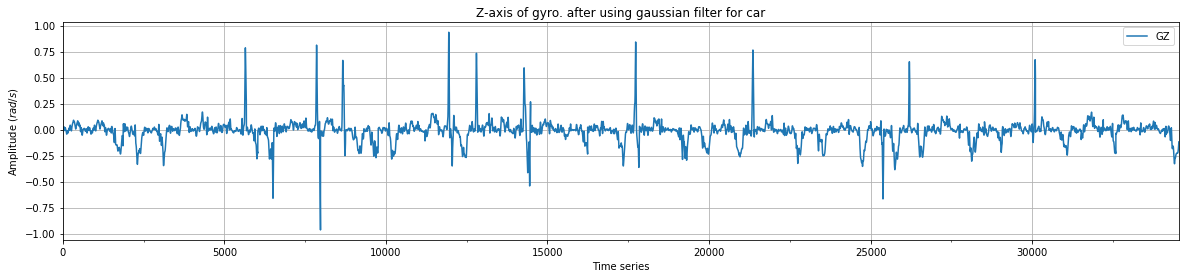

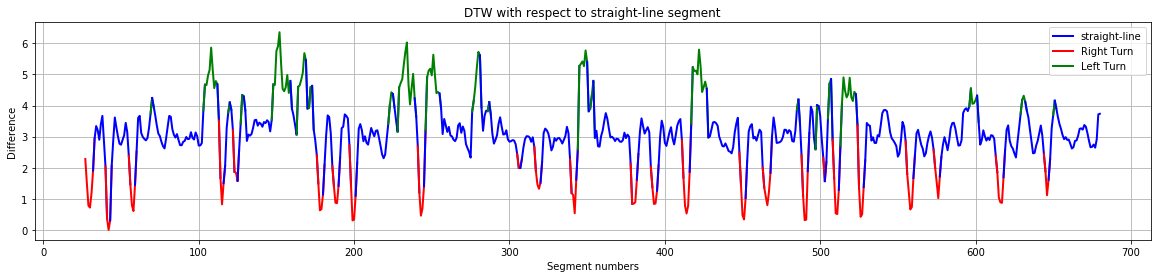

In [129]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series

x = np.arange(len(y))
print(len(y))
print(len(x))

car_colors = color_mapping(car_labelsy = car_segments[42][0])
car_colors
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

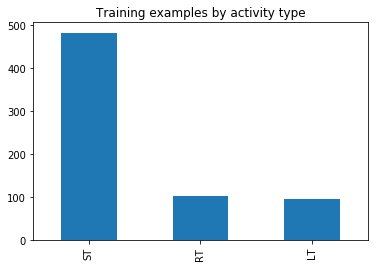

In [130]:
car_lables1= pd.Series(car_labels
                     )
car_lables1.value_counts().plot(kind='bar', title='Training examples by activity type');

In [131]:
x = car_segments
dist_fun = manhattan_distances
y = car_segments[11][0]
# dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
diff_wrt_ST, car_labels1 = loss_for_segments(x, y ,dist_fun)
loss_series_st = pd.Series(diff_wrt_ST)
loss_series.to_csv('diff_wrt_ST_car')

0 => 0.818154175488
1 => 0.675586177917
2 => 0.812375363549
3 => 0.914436393927
4 => 0.808648762704
5 => 0.788313386796
6 => 0.845812670905
7 => 0.708417186624
8 => 0.6805169259
9 => 0.563645380371
10 => 0.30781014592
11 => 0.0
12 => 0.25821895558
13 => 0.425878394308
14 => 0.4683264722
15 => 0.822410635338
16 => 0.668889715747
17 => 0.795108841832
18 => 0.910706842279
19 => 0.81035034836
20 => 0.779774824208
21 => 0.869056576723
22 => 0.990364529333
23 => 1.1733711502
24 => 1.5054445976
25 => 1.97199891289
26 => 2.48402608637
27 => 2.33046943819
28 => 2.18276553119
29 => 2.28805455566
30 => 2.36055227842
31 => 2.31403124676
32 => 2.31411940374
33 => 2.24869634625
34 => 1.90699180899
35 => 1.60668664265
36 => 1.75487222592
37 => 2.40671021615
38 => 2.86891887835
39 => 2.81930299381
40 => 2.60309825019
41 => 2.69096384817
42 => 2.81787563316
43 => 2.74981842728
44 => 2.81602218325
45 => 2.650416194
46 => 2.43082780564
47 => 1.63759286816
48 => 1.07791486231
49 => 0.478830953722
50 => 0.

392 => 2.37028163806
393 => 2.41508965703
394 => 2.56419396149
395 => 2.46456539196
396 => 2.4777242864
397 => 2.29071339862
398 => 1.962822716
399 => 1.58517360273
400 => 0.855817555684
401 => 0.517263072937
402 => 0.697580003873
403 => 0.498698866138
404 => 0.485124528742
405 => 0.583423873129
406 => 0.774533614191
407 => 0.922574549611
408 => 1.63596691887
409 => 2.23566213571
410 => 2.79449951631
411 => 2.88950587813
412 => 2.61575560086
413 => 2.62521867015
414 => 2.78406995699
415 => 2.74994438917
416 => 2.77745640634
417 => 3.12212652744
418 => 4.36082006934
419 => 4.15037740577
420 => 4.08547413989
421 => 3.89658940611
422 => 3.82584028312
423 => 3.8271756296
424 => 3.96053788823
425 => 3.92381749091
426 => 3.90545198177
427 => 3.55582292272
428 => 0.46833663002
429 => 0.736076386052
430 => 0.7577308514
431 => 0.796384222946
432 => 0.875296751237
433 => 0.833023726291
434 => 0.856636750573
435 => 0.869090140117
436 => 0.811832406211
437 => 0.744492092932
438 => 0.726352051356
4

681
681


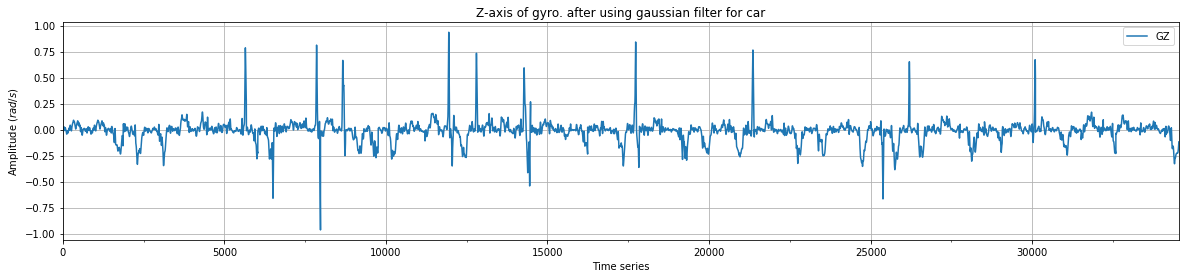

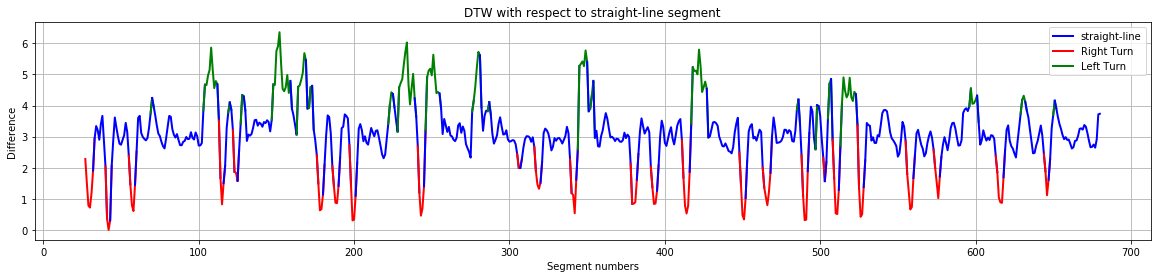

In [132]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series

x = np.arange(len(y))
print(len(y))
print(len(x))

car_colors = color_mapping(car_labels)
car_colors
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

In [143]:
x = car_segments
dist_fun = manhattan_distances
y = car_segments[109][0]
# dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
diff_wrt_RT, car_labels1 = loss_for_segments(x, y ,dist_fun)
loss_series_rt = pd.Series(diff_wrt_RT)
loss_series.to_csv('diff_wrt_rT_car')

0 => 3.79218868926
1 => 3.66091895822
2 => 3.37958490204
3 => 3.41426367942
4 => 3.51334123298
5 => 3.39940383026
6 => 3.50096173126
7 => 3.61375849219
8 => 3.83654604513
9 => 3.90461534735
10 => 3.90652828971
11 => 3.79470578811
12 => 3.82278021414
13 => 3.89456499009
14 => 3.92591769938
15 => 3.78850769809
16 => 3.68473433168
17 => 3.3797178038
18 => 3.4107350994
19 => 3.52207831216
20 => 3.39932241365
21 => 3.49062578462
22 => 3.60453089762
23 => 3.8606952818
24 => 3.99976053327
25 => 4.04245520687
26 => 4.17065534879
27 => 4.28696970705
28 => 4.46572735401
29 => 4.47757967936
30 => 5.35506924885
31 => 5.5771500828
32 => 4.89708135744
33 => 4.25658984089
34 => 4.07159682003
35 => 3.89619035717
36 => 4.03104002319
37 => 4.18471359274
38 => 4.24855483233
39 => 4.52076078229
40 => 4.53556670586
41 => 4.44692969051
42 => 5.18406736168
43 => 5.86610731162
44 => 5.13855633132
45 => 4.97860215953
46 => 4.5511755217
47 => 4.1831339982
48 => 4.0329035268
49 => 3.88188303487
50 => 3.903939815

399 => 3.97991944452
400 => 3.81916533934
401 => 3.88220095557
402 => 3.9569316859
403 => 3.74980046277
404 => 3.45197427094
405 => 3.35482689479
406 => 3.4211711262
407 => 3.61030246646
408 => 3.42881853896
409 => 3.61978058825
410 => 4.18659224773
411 => 4.45488662468
412 => 4.65801916602
413 => 4.90341406131
414 => 5.48466565898
415 => 5.88778824945
416 => 5.25781340375
417 => 5.08105295907
418 => 6.00743853345
419 => 5.51181983512
420 => 5.1568623555
421 => 5.23892181509
422 => 1.59649885247
423 => 0.559192809783
424 => 0.777707025636
425 => 5.03643867809
426 => 5.05069204469
427 => 5.28668462161
428 => 3.86869390815
429 => 3.95547561974
430 => 3.72791129407
431 => 3.37377118205
432 => 3.37403839602
433 => 3.5515392159
434 => 3.39238495531
435 => 3.16614362659
436 => 3.21186899194
437 => 3.92125574374
438 => 3.95920021297
439 => 3.98221900133
440 => 3.95938425025
441 => 3.959316061
442 => 3.55623752717
443 => 3.57841143996
444 => 3.84598695638
445 => 3.90833896574
446 => 4.04091978

681
681


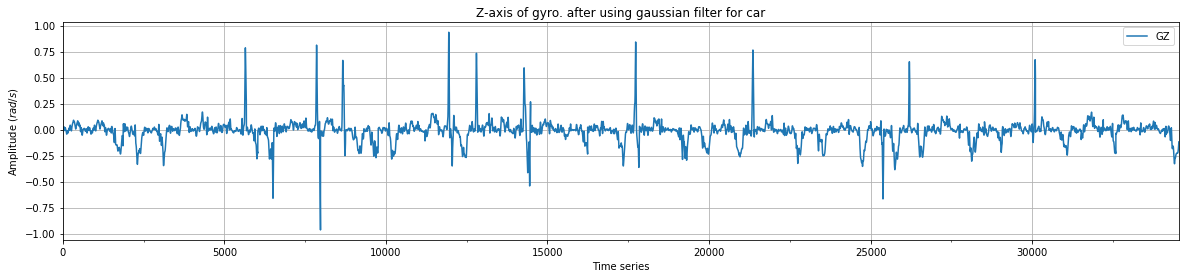

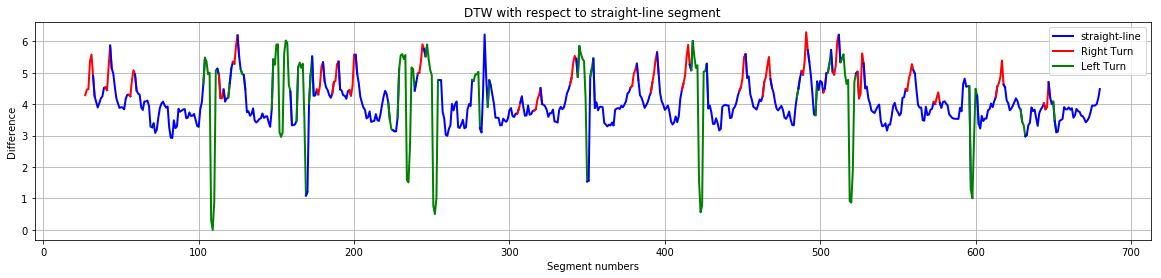

In [145]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series_rt

x = np.arange(len(y))
print(len(y))
print(len(x))

car_colors = color_mapping(car_labels)
car_colors
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

In [164]:
  
path_acc = os.getcwd() + '/data/Car1109in/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car1109in/*/*Gyroscope.csv' 

print(path_acc)

acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df1= read_files(acc_files[0], gyro_files[0], 'car')
n = len(df1)
df1 = df1[500:n-600]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    df_this = df_this[500 : n-600]
    print("len of this file ",df_this.shape)
    df1 = pd.concat([df1, df_this])
    print(df1.shape)
df1.reset_index(drop = True, inplace = True)
df1.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/*/*AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-49-13/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-49-13/Gyroscope.csv
len of this file  (700, 15)
(1400, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-22-09/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-22-09/Gyroscope.csv
len of this file  (83, 15)
(1483, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-47-56/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-47-56/Gyroscope.csv
len of this file  (959, 15)
(2442, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-13-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-13-25/Gyroscope.csv
len o

(26009, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-57-20/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-57-20/Gyroscope.csv
len of this file  (1016, 15)
(27025, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-43-51/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-43-51/Gyroscope.csv
len of this file  (1033, 15)
(28058, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-38-52/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-38-52/Gyroscope.csv
len of this file  (1049, 15)
(29107, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-14-28/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-14-28/Gyroscope.csv
len of this file  (311, 15)
(29418, 15)
/home/vicky/Desktop/Dhananjay/hum

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,-0.078869,-0.188007,0.070541,0.012077,0.007819,0.027154,car,-0.065445,0.015683,-0.825888,0.922741,-0.022174,-0.825888,0.922741,-0.022174
1,-0.076141,-0.195744,0.069358,0.012012,0.007699,0.026396,car,-0.067509,0.015369,0.384957,-0.430676,0.010557,0.384957,-0.430676,0.010557
2,-0.073515,-0.202591,0.067808,0.011851,0.007478,0.025336,car,-0.069433,0.014888,-0.822077,0.918355,-0.022309,-0.822077,0.918355,-0.022309
3,-0.071023,-0.208544,0.065932,0.011603,0.007182,0.024010,car,-0.071212,0.014265,0.384284,-0.430754,0.010639,0.384284,-0.430754,0.010639
4,-0.068689,-0.213629,0.063755,0.011284,0.006829,0.022459,car,-0.072855,0.013524,-0.818287,0.914052,-0.022004,-0.818287,0.914052,-0.022004


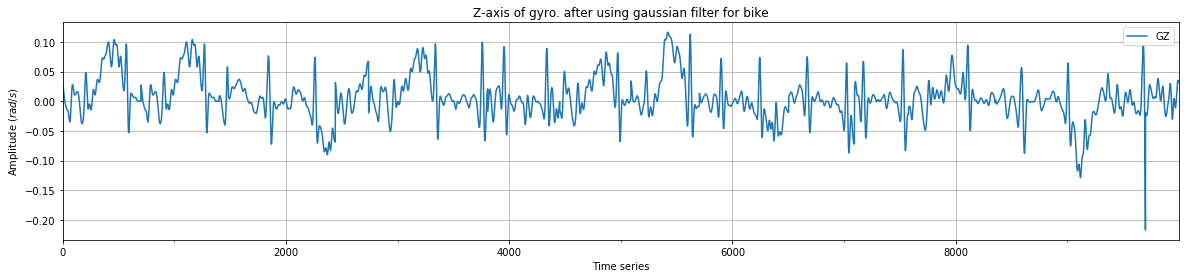

In [166]:
fig, ax = plt.subplots()
df1[['GZ']][0:10000].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:10000])
major_ticks = np.arange(0, n, 2000)
minor_ticks = np.arange(0, n, 1000)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [ ]:
car_segments, car_labels = segmentation(df, 500)
np.array(car_segments).shape
print(len(car_segments))